In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
# sys.path.append('E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/TCSA_SNN')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from simple_utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
    summarize_eco2ai_log,
    )

import resnet_2_copy

from datetime import datetime
import glob
import random

# from fvcore.nn import FlopCountAnalysis
# from thop import profile
# from ptflops import get_model_complexity_info

from eco2ai import Tracker
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet_2_copy.resnet34().to(device)
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Snn_Conv2d-1      [32, 2, 64, 128, 128]           3,136
      BatchNorm3d1-2      [32, 64, 4, 128, 128]             128
     batch_norm_2d-3      [32, 2, 64, 128, 128]               0
        mem_update-4      [32, 2, 64, 128, 128]               0
        Snn_Conv2d-5        [32, 2, 64, 64, 64]          36,864
      BatchNorm3d1-6        [32, 64, 4, 64, 64]             128
     batch_norm_2d-7        [32, 2, 64, 64, 64]               0
        mem_update-8        [32, 2, 64, 64, 64]               0
        Snn_Conv2d-9        [32, 2, 64, 64, 64]          36,864
     BatchNorm3d2-10        [32, 64, 4, 64, 64]             128
   batch_norm_2d1-11        [32, 2, 64, 64, 64]               0
AdaptiveAvgPool3d-12           [32, 4, 1, 1, 1]               0
           Conv3d-13           [32, 1, 1, 1, 1]               4
             ReLU-14           [32, 1, 

In [ ]:
macs, params = get_model_complexity_info(model, (1, 256, 256), as_strings=True)
print(f"SNN TCSA MACs: {macs}, Params: {params}")

ResNet_origin(
  1.2 M, 5.335% Params, 719.67 MMac, 94.225% MACs, 
  (conv1): Sequential(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (0): Snn_Conv2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): batch_norm_2d(
      0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
      (bn): BatchNorm3d1(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool): MaxPool2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (mem_update): mem_update(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (conv2_x): Sequential(
    4.69 k, 0.021% Params, 20.15 MMac, 2.639% MACs, 
    (0): BasicBlock(
      1.56 k, 0.007% Params, 9.51 MMac, 1.246% MACs, 
      (residual_function): Sequential(
        1.56 k, 0.007% Params, 5.32 MMac, 0.697% MACs, 
        (0): mem_update(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
        (1): 

In [5]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation.zip"
extract_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted"

# # Extract ZIP
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)

['Modified_3_Brain_Tumor_Segmentation']

In [6]:
IMG_DIR      =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [7]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3
Batch_size  = 32
num_epochs  = 30
num_workers = 4
IMAGE_HEIGHT = 256 # 256 -> 512 originally
IMAGE_WIDTH  = 256 # 256 -> 512 originally
PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_NAME = None

In [8]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    tracker = Tracker(
        project_name="TCSA_SNN_Training_Project",
        experiment_description="Training TCSA Spiking Model",
        file_name="TCSA_SNN_eco2ai_logs.csv",
        alpha_2_code="EG",
    )
    tracker.start()

    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device)

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

    tracker.stop()

    nasar = model.calculate_nasar()

    return running_loss/len(loader), nasar

In [9]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = resnet_2_copy.resnet34().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]
    train_nasar=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        val_acc_loaded, val_dice_loaded = check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

In [10]:
if __name__ == "__main__":
    main()

100%|██████████| 82/82 [10:08<00:00,  7.42s/it, loss=0.0524]


NASAR: 0.25538355867627643


100%|██████████| 82/82 [02:46<00:00,  2.03s/it, loss=0.0473]


NASAR: 0.2441329687414035


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.052]


NASAR: 0.242459838938825


100%|██████████| 82/82 [02:46<00:00,  2.03s/it, loss=0.035]


NASAR: 0.2248584227942525


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0333]


NASAR: 0.225679916954936


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0438]


NASAR: 0.21757833274877128


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0298]


NASAR: 0.2168890008344337


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0358]


NASAR: 0.22002475362428478


100%|██████████| 82/82 [02:46<00:00,  2.02s/it, loss=0.0291]


NASAR: 0.21497628834325944


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0281]


NASAR: 0.2037930645293473


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0267]


NASAR: 0.20187919688336725


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.024]


NASAR: 0.19718708342789484


100%|██████████| 82/82 [02:46<00:00,  2.03s/it, loss=0.0294]


NASAR: 0.18605568039585169


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0251]


NASAR: 0.19546063741048178


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0307]


NASAR: 0.17955386918475372


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0235]


NASAR: 0.1804484873310501


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0258]


NASAR: 0.17320356234698228


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0266]


NASAR: 0.18264952287987365


100%|██████████| 82/82 [02:46<00:00,  2.03s/it, loss=0.0175]


NASAR: 0.18012919000616656


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0273]


NASAR: 0.1689035478332233


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0185]


NASAR: 0.16625493009325484


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0196]


NASAR: 0.16268560024494297


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0156]


NASAR: 0.1569754551274116


100%|██████████| 82/82 [02:46<00:00,  2.03s/it, loss=0.0171]


NASAR: 0.15968195597330728


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0187]


NASAR: 0.16241140768561566


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.02]


NASAR: 0.15345382690429688


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0413]


NASAR: 0.1336101836441828


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0202]


NASAR: 0.15331954239679615


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0187]


NASAR: 0.14290361001457966


100%|██████████| 82/82 [02:45<00:00,  2.02s/it, loss=0.0175]


NASAR: 0.14953693873445753


In [ ]:
from google.colab import files

# Download the Eco2AI Logs
files.download("TCSA_SNN_eco2ai_logs.csv")

✅ Log loaded successfully.

🔍 Summary:
   🕒 Duration: 5420.52 seconds
   ⚡ Power Consumed: 0.1369 kWh
   🌱 CO₂ Emissions: 0.0644 kg


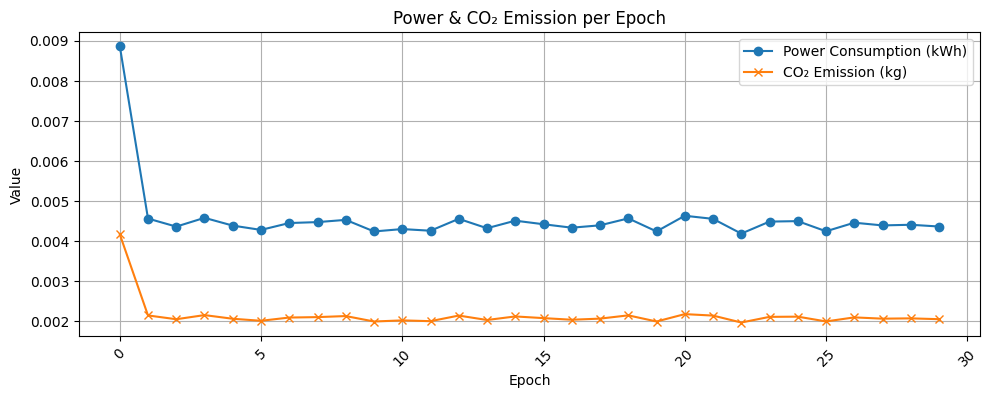

✅ Summary plot saved as 'TCSA_SNN_eco2ai_summary_plot.png'.


In [11]:
summarize_eco2ai_log("TCSA_SNN_eco2ai_logs.csv")

In [12]:
# Download the Eco2AI Plot
files.download("TCSA_SNN_eco2ai_summary_plot.png")

NameError: name 'files' is not defined